# Regresi√≥n Lineal v3 - Modelo con 6 Per√≠odos Hist√≥ricos

Esta notebook implementa un modelo de regresi√≥n lineal para predecir las ventas (en toneladas) de productos 2 meses en el futuro, espec√≠ficamente para febrero 2020, usando datos hist√≥ricos hasta diciembre 2019.

**Diferencia con v2:** Este modelo utiliza solo **6 per√≠odos hist√≥ricos** (tn_0 a tn_5) en lugar de 12, lo que puede reducir el overfitting y mejorar la generalizaci√≥n del modelo con menos variables predictoras.

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np


In [51]:

# Load the sales data (tab-delimited)
sell_in = pd.read_csv("datasets/sell-in.txt", sep="\t", dtype={"periodo": str})

# Load the stocks data (tab-delimited)
stocks = pd.read_csv("datasets/tb_stocks.txt", sep="\t", dtype={"periodo": str})

# Load the product information data (tab-delimited)
productos_info = pd.read_csv("datasets/tb_productos.txt", sep="\t")

#carga productos a predecir
productos_a_predecir = pd.read_csv("datasets/product_id_apredecir201912.txt", sep="\t",header=0)

In [52]:
#BORRAR
# import pandas as pd


# # 1) Carga de datos
# sell_in       = pd.read_csv('../data/sell-in.txt', sep='\t')
# prod_vigentes = pd.read_csv('../data/product_id_apredecir201912.txt', sep='\t')  # contiene al menos product_id
# productos = pd.read_csv('../data/tb_productos_05262025.txt', sep='\t')  # contiene al menos product_id


In [53]:
# 2) Parseo de 'periodo' a datetime
sell_in['periodo'] = pd.to_datetime(
    sell_in['periodo'].astype(str) + '01',
    format='%Y%m%d'
)

In [54]:
sell_in.head(10)

periodo  customer_id  product_id  plan_precios_cuidados  \
0 2017-01-01        10234       20524                      0   
1 2017-01-01        10032       20524                      0   
2 2017-01-01        10217       20524                      0   
3 2017-01-01        10125       20524                      0   
4 2017-01-01        10012       20524                      0   
5 2017-01-01        10080       20524                      0   
6 2017-01-01        10015       20524                      0   
7 2017-01-01        10062       20524                      0   
8 2017-01-01        10159       20524                      0   
9 2017-01-01        10183       20524                      0   

   cust_request_qty  cust_request_tn       tn  
0                 2          0.05300  0.05300  
1                 1          0.13628  0.13628  
2                 1          0.03028  0.03028  
3                 1          0.02271  0.02271  
4                11          1.54452  1.54452  
5                 1          0.01514  0.01514  
6                 4          0.10600  0.10600  
7                 1          0.18928  0.18928  
8                 3          0.02271  0.02271  
9                 1          0.01514  0.01514

In [55]:
sell_in.shape

(2945818, 7)

In [56]:
# sumatoria de cust_request_qty, cust_request_tn y tn por periodo, product_id
#cambiar nombre sell_in_agg por sell_in_acumulado
sell_in_agg = (
    sell_in
    .groupby(['periodo','product_id'], as_index=False)
    .agg({
        'tn': 'sum',
        'cust_request_qty': 'sum',
        'cust_request_tn': 'sum'
    })
)

In [57]:
# hacer un join con productos_a_predecir para trabajar s√≥lo con eso

sell_in_agg = sell_in_agg.merge(
    productos_a_predecir[['product_id']],
    on='product_id',
    how='inner'
)

In [58]:
sell_in_agg.drop(columns=['cust_request_qty', 'cust_request_tn'], inplace=True)
sell_in_agg

periodo  product_id          tn
0     2017-01-01       20001   934.77222
1     2017-01-01       20002   550.15707
2     2017-01-01       20003  1063.45835
3     2017-01-01       20004   555.91614
4     2017-01-01       20005   494.27011
...          ...         ...         ...
22344 2019-12-01       21263     0.01270
22345 2019-12-01       21265     0.05007
22346 2019-12-01       21266     0.05121
22347 2019-12-01       21267     0.01569
22348 2019-12-01       21276     0.00892

[22349 rows x 3 columns]

In [59]:
# Crear un nuevo campo llamado tn_mas_2 que es el campo tn de 2 periodos a futuro
sell_in_agg['tn_mas_2'] = sell_in_agg.groupby(['product_id'])['tn'].shift(-2)


In [60]:
sell_in_agg

periodo  product_id          tn    tn_mas_2
0     2017-01-01       20001   934.77222  1303.35771
1     2017-01-01       20002   550.15707   834.73521
2     2017-01-01       20003  1063.45835   917.16548
3     2017-01-01       20004   555.91614   489.91328
4     2017-01-01       20005   494.27011   563.89955
...          ...         ...         ...         ...
22344 2019-12-01       21263     0.01270         NaN
22345 2019-12-01       21265     0.05007         NaN
22346 2019-12-01       21266     0.05121         NaN
22347 2019-12-01       21267     0.01569         NaN
22348 2019-12-01       21276     0.00892         NaN

[22349 rows x 4 columns]

In [61]:
sell_in_agg[sell_in_agg['periodo'] == '2019-12-01']

periodo  product_id          tn  tn_mas_2
21569 2019-12-01       20001  1504.68856       NaN
21570 2019-12-01       20002  1087.30855       NaN
21571 2019-12-01       20003   892.50129       NaN
21572 2019-12-01       20004   637.90002       NaN
21573 2019-12-01       20005   593.24443       NaN
...          ...         ...         ...       ...
22344 2019-12-01       21263     0.01270       NaN
22345 2019-12-01       21265     0.05007       NaN
22346 2019-12-01       21266     0.05121       NaN
22347 2019-12-01       21267     0.01569       NaN
22348 2019-12-01       21276     0.00892       NaN

[780 rows x 4 columns]

In [62]:
sell_in_agg['mean_last_3m'] = (
    sell_in_agg
      .groupby('product_id')['tn']
      .apply(lambda x: x.rolling(window=3, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)

In [ ]:
for lag in range (1, 7):  # Cambiado de 12 a 7 para usar solo 6 lags (tn_1 a tn_6)
    sell_in_agg[f'tn_{lag}'] = (sell_in_agg
        .groupby(['product_id'])['tn']
        .shift(lag)
    )

In [64]:
# Renombrar el campo tn a tn_0
sell_in_agg.rename(columns={'tn': 'tn_0'}, inplace=True)

In [65]:
sell_in_agg


periodo  product_id        tn_0    tn_mas_2  mean_last_3m     tn_1  \
0     2017-01-01       20001   934.77222  1303.35771    934.772220      NaN   
1     2017-01-01       20002   550.15707   834.73521    550.157070      NaN   
2     2017-01-01       20003  1063.45835   917.16548   1063.458350      NaN   
3     2017-01-01       20004   555.91614   489.91328    555.916140      NaN   
4     2017-01-01       20005   494.27011   563.89955    494.270110      NaN   
...          ...         ...         ...         ...           ...      ...   
22344 2019-12-01       21263     0.01270         NaN      0.020230  0.03247   
22345 2019-12-01       21265     0.05007         NaN      0.075093  0.06600   
22346 2019-12-01       21266     0.05121         NaN      0.078883  0.06713   
22347 2019-12-01       21267     0.01569         NaN      0.050990  0.04052   
22348 2019-12-01       21276     0.00892         NaN      0.021040  0.03341   

          tn_2     tn_3     tn_4     tn_5     tn_6     tn_7     tn_8     tn_9  \
0          NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1          NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2          NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
3          NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
4          NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
...        ...      ...      ...      ...      ...      ...      ...      ...   
22344  0.01552  0.01128  0.03388  0.03387  0.00988  0.02258  0.01835  0.06636   
22345  0.10921  0.01707  0.01593  0.02959  0.05121  0.17635  0.36405  0.01593   
22346  0.11831  0.02844  0.01480  0.05916  0.05235  0.17634  0.36178  0.01707   
22347  0.09676  0.01830  0.04054  0.07452  0.05882  0.24451  0.12291  0.21578   
22348  0.02079  0.01856  0.01265  0.00223  0.04086  0.09283  0.10173  0.12249   

         tn_10    tn_11  
0          NaN      NaN  
1          NaN      NaN  
2          NaN      NaN  
3          NaN      NaN  
4          NaN      NaN  
...        ...      ...  
22344  0.05927  0.04376  
22345      NaN      NaN  
22346      NaN      NaN  
22347      NaN      NaN  
22348      NaN      NaN  

[22349 rows x 16 columns]

In [ ]:
from sklearn.linear_model import LinearRegression

#  Filtras s√≥lo diciembre 2018 y eliminas filas incompletas:
# Ahora solo necesitamos 6 variables (tn_0 a tn_5) en lugar de 12
dataset_training = (
        sell_in_agg[sell_in_agg['periodo'] == '2018-12-01']
      .dropna(subset=['tn_mas_2'] + [f'tn_{i}' for i in range(6)])  # Cambiado de 12 a 6  # Cambiado de 12 a 6
)

In [67]:
dataset_training

periodo  product_id        tn_0    tn_mas_2  mean_last_3m  \
12906 2018-12-01       20001  1486.68669  1259.09363   1864.966707   
12907 2018-12-01       20002  1009.45458  1043.01349   1384.918527   
12908 2018-12-01       20003   769.82869   758.32657   1096.696177   
12909 2018-12-01       20004   585.56477   441.70332    732.527440   
12910 2018-12-01       20005   372.63428   409.89950    578.546193   
...          ...         ...         ...         ...           ...   
13545 2018-12-01       21207     0.12478     0.18451      0.125490   
13547 2018-12-01       21212     0.09869     0.12051      0.159813   
13548 2018-12-01       21218     0.03092     0.05751      0.045113   
13549 2018-12-01       21222     0.02839     0.03786      0.049983   
13550 2018-12-01       21224     0.07982     0.08571      0.064903   

             tn_1        tn_2        tn_3        tn_4        tn_5        tn_6  \
12906  1813.01511  2295.19832  1438.67455  1800.96168  1470.41009  1150.79169   
12907  1766.81068  1378.49032   954.23575  1161.88430   977.40239  1033.82845   
12908  1206.91773  1313.34211   912.34156   955.97079   656.22700   660.73323   
12909   802.34669   809.67086   948.86342   936.42001   653.42310   447.84475   
12910   469.26344   893.74086   761.77520   874.88924   502.34077   547.62513   
...           ...         ...         ...         ...         ...         ...   
13545     0.11475     0.13694     0.12438     0.18884     0.21173     0.24206   
13547     0.13082     0.24993     0.12490     0.17085     0.16847     0.21680   
13548     0.02618     0.07824     0.07952     0.20672     0.16725     0.09627   
13549     0.04150     0.08006     0.06261     0.09394     0.09829     0.08301   
13550     0.05231     0.06258     0.06121     0.06555     0.08918     0.18093   

             tn_7        tn_8        tn_9       tn_10       tn_11  
12906  1293.89788  1251.28462  1856.83534  1043.76470  1169.07532  
12907  1103.39191   999.20934   966.86044   712.00087   984.80167  
12908   784.35885   765.47838   778.55594   788.30749   907.56304  
12909   641.37063   611.51237   488.92473   503.65326   415.52538  
12910   637.11135   496.41774   559.98671   399.20878   417.53208  
...           ...         ...         ...         ...         ...  
13545     0.21064     0.19744     0.35279     0.27239     0.39088  
13547     0.28263     0.19330     0.22093     0.22882     0.24341  
13548     0.14214     0.19183     0.16635     0.03003     0.04950  
13549     0.09830     0.09173     0.06919     0.04879     0.12522  
13550     0.07200     0.10316     0.11667     0.07088     0.10501  

[567 rows x 16 columns]

In [68]:

dataset_training.drop(columns=['periodo'], inplace=True)

In [69]:
dataset_training

product_id        tn_0    tn_mas_2  mean_last_3m        tn_1  \
12906       20001  1486.68669  1259.09363   1864.966707  1813.01511   
12907       20002  1009.45458  1043.01349   1384.918527  1766.81068   
12908       20003   769.82869   758.32657   1096.696177  1206.91773   
12909       20004   585.56477   441.70332    732.527440   802.34669   
12910       20005   372.63428   409.89950    578.546193   469.26344   
...           ...         ...         ...           ...         ...   
13545       21207     0.12478     0.18451      0.125490     0.11475   
13547       21212     0.09869     0.12051      0.159813     0.13082   
13548       21218     0.03092     0.05751      0.045113     0.02618   
13549       21222     0.02839     0.03786      0.049983     0.04150   
13550       21224     0.07982     0.08571      0.064903     0.05231   

             tn_2        tn_3        tn_4        tn_5        tn_6        tn_7  \
12906  2295.19832  1438.67455  1800.96168  1470.41009  1150.79169  1293.89788   
12907  1378.49032   954.23575  1161.88430   977.40239  1033.82845  1103.39191   
12908  1313.34211   912.34156   955.97079   656.22700   660.73323   784.35885   
12909   809.67086   948.86342   936.42001   653.42310   447.84475   641.37063   
12910   893.74086   761.77520   874.88924   502.34077   547.62513   637.11135   
...           ...         ...         ...         ...         ...         ...   
13545     0.13694     0.12438     0.18884     0.21173     0.24206     0.21064   
13547     0.24993     0.12490     0.17085     0.16847     0.21680     0.28263   
13548     0.07824     0.07952     0.20672     0.16725     0.09627     0.14214   
13549     0.08006     0.06261     0.09394     0.09829     0.08301     0.09830   
13550     0.06258     0.06121     0.06555     0.08918     0.18093     0.07200   

             tn_8        tn_9       tn_10       tn_11  
12906  1251.28462  1856.83534  1043.76470  1169.07532  
12907   999.20934   966.86044   712.00087   984.80167  
12908   765.47838   778.55594   788.30749   907.56304  
12909   611.51237   488.92473   503.65326   415.52538  
12910   496.41774   559.98671   399.20878   417.53208  
...           ...         ...         ...         ...  
13545     0.19744     0.35279     0.27239     0.39088  
13547     0.19330     0.22093     0.22882     0.24341  
13548     0.19183     0.16635     0.03003     0.04950  
13549     0.09173     0.06919     0.04879     0.12522  
13550     0.10316     0.11667     0.07088     0.10501  

[567 rows x 15 columns]

In [ ]:
# # 3) Definir X e y:
# feature_cols = [f'tn_{i}' for i in range(6)]   # ['tn_0','tn_1',‚Ä¶,'tn_5'] - Cambiado de 12 a 6
# X_train = dataset_training[feature_cols]
# y_train = dataset_training['tn_mas_2']

In [71]:
# # 4) Ajustar la regresi√≥n lineal:
# lr = LinearRegression()
# lr.fit(X_train, y_train)


In [72]:


# # 5) Echa un vistazo a R¬≤ en el mismo train (o en cross-val):
# print("R¬≤ en diciembre 2018:", lr.score(X_train, y_train))

# # 6) Cuando quieras predecir febrero 2020, construye otro 
# #    DataFrame an√°logo para periodo='2019-12-01' y usa:
# # X_new = df[df['periodo']=='2019-12-01'][feature_cols]
# # y_pred = lr.predict(X_new)

In [73]:
# PASO 1: Preparar el dataset completo para entrenamiento
# En esta versi√≥n NO filtramos productos "m√°gicos"
# Usaremos TODOS los productos disponibles en diciembre 2018 que tengan datos completos
# Esto deber√≠a dar un modelo m√°s robusto y generalizable

print(f"Dataset de entrenamiento original: {len(dataset_training)} productos")
print(f"Productos disponibles para entrenar el modelo con datos completos")

Dataset de entrenamiento original: 567 productos
Productos disponibles para entrenar el modelo con datos completos


In [74]:
# PASO 2: Usar el dataset completo de entrenamiento
# Usamos directamente el dataset_training que ya contiene todos los productos
# de diciembre 2018 con datos completos (sin NaN)
df_completo = dataset_training.copy()
print(f"Entrenando con {len(df_completo)} productos")

Entrenando con 567 productos


In [75]:
# PASO 3: Preparar el dataset sin filtros
# NO filtramos por productos espec√≠ficos - usamos todos los disponibles
# Solo establecemos product_id como √≠ndice para facilitar las operaciones
df_completo = df_completo.set_index('product_id')
print(f"Dataset preparado con {len(df_completo)} productos")

Dataset preparado con 567 productos


In [76]:
# PASO 4: Limpiar el dataset eliminando columnas innecesarias
# Eliminamos 'mean_last_3m' porque no la vamos a usar como feature en el modelo
# Solo queremos las columnas tn_0, tn_1, ..., tn_11 como variables predictoras
df_completo.drop(columns=['mean_last_3m'], inplace=True)
print(f"Columnas disponibles: {list(df_completo.columns)}")
df_completo

Columnas disponibles: ['tn_0', 'tn_mas_2', 'tn_1', 'tn_2', 'tn_3', 'tn_4', 'tn_5', 'tn_6', 'tn_7', 'tn_8', 'tn_9', 'tn_10', 'tn_11']


tn_0    tn_mas_2        tn_1        tn_2        tn_3  \
product_id                                                               
20001       1486.68669  1259.09363  1813.01511  2295.19832  1438.67455   
20002       1009.45458  1043.01349  1766.81068  1378.49032   954.23575   
20003        769.82869   758.32657  1206.91773  1313.34211   912.34156   
20004        585.56477   441.70332   802.34669   809.67086   948.86342   
20005        372.63428   409.89950   469.26344   893.74086   761.77520   
...                ...         ...         ...         ...         ...   
21207          0.12478     0.18451     0.11475     0.13694     0.12438   
21212          0.09869     0.12051     0.13082     0.24993     0.12490   
21218          0.03092     0.05751     0.02618     0.07824     0.07952   
21222          0.02839     0.03786     0.04150     0.08006     0.06261   
21224          0.07982     0.08571     0.05231     0.06258     0.06121   

                  tn_4        tn_5        tn_6        tn_7        tn_8  \
product_id                                                               
20001       1800.96168  1470.41009  1150.79169  1293.89788  1251.28462   
20002       1161.88430   977.40239  1033.82845  1103.39191   999.20934   
20003        955.97079   656.22700   660.73323   784.35885   765.47838   
20004        936.42001   653.42310   447.84475   641.37063   611.51237   
20005        874.88924   502.34077   547.62513   637.11135   496.41774   
...                ...         ...         ...         ...         ...   
21207          0.18884     0.21173     0.24206     0.21064     0.19744   
21212          0.17085     0.16847     0.21680     0.28263     0.19330   
21218          0.20672     0.16725     0.09627     0.14214     0.19183   
21222          0.09394     0.09829     0.08301     0.09830     0.09173   
21224          0.06555     0.08918     0.18093     0.07200     0.10316   

                  tn_9       tn_10       tn_11  
product_id                                      
20001       1856.83534  1043.76470  1169.07532  
20002        966.86044   712.00087   984.80167  
20003        778.55594   788.30749   907.56304  
20004        488.92473   503.65326   415.52538  
20005        559.98671   399.20878   417.53208  
...                ...         ...         ...  
21207          0.35279     0.27239     0.39088  
21212          0.22093     0.22882     0.24341  
21218          0.16635     0.03003     0.04950  
21222          0.06919     0.04879     0.12522  
21224          0.11667     0.07088     0.10501  

[567 rows x 13 columns]

In [77]:
# Informaci√≥n del dataset completo
print("Informaci√≥n del dataset completo para entrenamiento:")
df_completo.info()

Informaci√≥n del dataset completo para entrenamiento:
<class 'pandas.core.frame.DataFrame'>
Index: 567 entries, 20001 to 21224
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tn_0      567 non-null    float64
 1   tn_mas_2  567 non-null    float64
 2   tn_1      567 non-null    float64
 3   tn_2      567 non-null    float64
 4   tn_3      567 non-null    float64
 5   tn_4      567 non-null    float64
 6   tn_5      567 non-null    float64
 7   tn_6      567 non-null    float64
 8   tn_7      567 non-null    float64
 9   tn_8      567 non-null    float64
 10  tn_9      567 non-null    float64
 11  tn_10     567 non-null    float64
 12  tn_11     567 non-null    float64
dtypes: float64(13)
memory usage: 62.0 KB


In [ ]:
# PASO 5: Preparar las variables para el modelo de regresi√≥n lineal
# X (variables predictoras): Los valores de ventas de los √∫ltimos 12 per√≠odos
feature_cols = [f'tn_{i}' for i in range(6)]   # ['tn_0','tn_1',‚Ä¶,'tn_5'] - Cambiado de 12 a 6\nX_train = df_completo[feature_cols]

# y (variable objetivo): El valor que queremos predecir (ventas 2 per√≠odos adelante)
y_train = df_completo['tn_mas_2']

print(f"Dimensiones del conjunto de entrenamiento:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"Total de productos para entrenar: {len(X_train)}")

Dimensiones del conjunto de entrenamiento:
X_train: (567, 12)
y_train: (567,)
Total de productos para entrenar: 567


In [79]:
# PASO 6: Entrenar el modelo de regresi√≥n lineal con TODOS los datos
# Creamos una instancia del modelo LinearRegression de scikit-learn
lr = LinearRegression()

# Entrenamos el modelo con TODOS los productos disponibles de diciembre 2018
# Esto deber√≠a dar un modelo m√°s robusto al usar m√°s datos de entrenamiento
print(f"Entrenando modelo con {len(X_train)} productos...")
lr.fit(X_train, y_train)
print("‚úì Modelo entrenado exitosamente")

Entrenando modelo con 567 productos...
‚úì Modelo entrenado exitosamente


In [80]:
# Entrenar el modelo

In [81]:
# PASO 7: Evaluar la calidad del modelo
# R¬≤ (coeficiente de determinaci√≥n) mide qu√© tan bien el modelo explica la variabilidad
# Valores cercanos a 1 indican un buen ajuste, valores cercanos a 0 indican mal ajuste
r2_score = lr.score(X_train, y_train)
print(f"R¬≤ en diciembre 2018 (con todos los datos): {r2_score:.4f}")
print(f"El modelo explica {r2_score*100:.2f}% de la variabilidad en los datos")

R¬≤ en diciembre 2018 (con todos los datos): 0.9777
El modelo explica 97.77% de la variabilidad en los datos


In [82]:
# PASO 8: Analizar los coeficientes del modelo entrenado con todos los datos
# Los coeficientes nos dicen cu√°nto peso tiene cada per√≠odo pasado en la predicci√≥n
# Coeficientes positivos: per√≠odos que contribuyen positivamente a las ventas futuras
# Coeficientes negativos: per√≠odos que contribuyen negativamente
coeficientes = pd.Series(lr.coef_, index=feature_cols)
coeficientes_ordenados = coeficientes.sort_values(ascending=False)

print("Coeficientes del modelo (ordenados por importancia):")
print(coeficientes_ordenados)
print(f"\nCoeficiente m√°s importante: {coeficientes_ordenados.index[0]} = {coeficientes_ordenados.iloc[0]:.4f}")
print(f"Coeficiente menos importante: {coeficientes_ordenados.index[-1]} = {coeficientes_ordenados.iloc[-1]:.4f}")

coeficientes_ordenados

Coeficientes del modelo (ordenados por importancia):
tn_0     0.314563
tn_2     0.160457
tn_10    0.140669
tn_11    0.123846
tn_1     0.119418
tn_7     0.097088
tn_6     0.071892
tn_8     0.060479
tn_9     0.041922
tn_5    -0.033436
tn_3    -0.059655
tn_4    -0.158985
dtype: float64

Coeficiente m√°s importante: tn_0 = 0.3146
Coeficiente menos importante: tn_4 = -0.1590


tn_0     0.314563
tn_2     0.160457
tn_10    0.140669
tn_11    0.123846
tn_1     0.119418
tn_7     0.097088
tn_6     0.071892
tn_8     0.060479
tn_9     0.041922
tn_5    -0.033436
tn_3    -0.059655
tn_4    -0.158985
dtype: float64

In [83]:
# PASO 9: Mostrar el intercepto del modelo
# El intercepto es el valor base de la predicci√≥n cuando todas las variables son 0
# Representa el "nivel base" de ventas independiente de los valores hist√≥ricos
print(f"Intercepto del modelo: {lr.intercept_:.4f}")
print("Este es el valor base de predicci√≥n cuando no hay historial de ventas")

Intercepto del modelo: 2.5486
Este es el valor base de predicci√≥n cuando no hay historial de ventas


In [84]:
# Realizar un merge entre sell_in para el periodo 2019-12-01 con prod_vigentes para quedarnos s√≥lo con los productos vigentes

# Crear un nuevo campo llamado tn_mas_2 que es el campo tn de 2 periodos a futuro
# sell_in_agg['tn_mas_2'] = sell_in_agg.groupby(['product_id'])['tn'].shift(-2)
dataset_201912_a_predecir = (
    sell_in_agg[sell_in_agg['periodo'] == '2019-12-01']
      .merge(productos_a_predecir[['product_id']], on='product_id', how='inner')
)
dataset_201912_a_predecir

periodo  product_id        tn_0  tn_mas_2  mean_last_3m        tn_1  \
0   2019-12-01       20001  1504.68856       NaN   1487.855463  1397.37231   
1   2019-12-01       20002  1087.30855       NaN   1496.807430  1423.57739   
2   2019-12-01       20003   892.50129       NaN    974.053890   948.29393   
3   2019-12-01       20004   637.90002       NaN    808.846137   723.94206   
4   2019-12-01       20005   593.24443       NaN    732.312970   606.91173   
..         ...         ...         ...       ...           ...         ...   
775 2019-12-01       21263     0.01270       NaN      0.020230     0.03247   
776 2019-12-01       21265     0.05007       NaN      0.075093     0.06600   
777 2019-12-01       21266     0.05121       NaN      0.078883     0.06713   
778 2019-12-01       21267     0.01569       NaN      0.050990     0.04052   
779 2019-12-01       21276     0.00892       NaN      0.021040     0.03341   

           tn_2        tn_3        tn_4        tn_5        tn_6        tn_7  \
0    1561.50552  1660.00561  1261.34529  1678.99318  1109.93769  1629.78233   
1    1979.53635  1090.18771   813.78215  1066.44999   928.36431  1034.98927   
2    1081.36645   967.77116   635.59563   715.20314   662.38654   590.12515   
3    1064.69633   786.17140   482.13372   521.71519   667.19411   603.31081   
4     996.78275   879.52808   536.66800   745.74978   876.39696   897.26297   
..          ...         ...         ...         ...         ...         ...   
775     0.01552     0.01128     0.03388     0.03387     0.00988     0.02258   
776     0.10921     0.01707     0.01593     0.02959     0.05121     0.17635   
777     0.11831     0.02844     0.01480     0.05916     0.05235     0.17634   
778     0.09676     0.01830     0.04054     0.07452     0.05882     0.24451   
779     0.02079     0.01856     0.01265     0.00223     0.04086     0.09283   

           tn_8        tn_9       tn_10       tn_11  
0    1647.63848  1470.65653  1259.09363  1275.77351  
1    1287.62346  1083.62552  1043.01349  1266.78751  
2     565.33774   638.04010   758.32657   964.76919  
3     466.70901   619.77084   441.70332   511.33713  
4     624.99880   488.21387   409.89950   363.58438  
..          ...         ...         ...         ...  
775     0.01835     0.06636     0.05927     0.04376  
776     0.36405     0.01593         NaN         NaN  
777     0.36178     0.01707         NaN         NaN  
778     0.12291     0.21578         NaN         NaN  
779     0.10173     0.12249         NaN         NaN  

[780 rows x 16 columns]

In [ ]:
dataset_201912_a_predecir.drop(columns=['tn_mas_2'], inplace=True)


In [86]:
dataset_201912_a_predecir

periodo  product_id        tn_0  mean_last_3m        tn_1        tn_2  \
0   2019-12-01       20001  1504.68856   1487.855463  1397.37231  1561.50552   
1   2019-12-01       20002  1087.30855   1496.807430  1423.57739  1979.53635   
2   2019-12-01       20003   892.50129    974.053890   948.29393  1081.36645   
3   2019-12-01       20004   637.90002    808.846137   723.94206  1064.69633   
4   2019-12-01       20005   593.24443    732.312970   606.91173   996.78275   
..         ...         ...         ...           ...         ...         ...   
775 2019-12-01       21263     0.01270      0.020230     0.03247     0.01552   
776 2019-12-01       21265     0.05007      0.075093     0.06600     0.10921   
777 2019-12-01       21266     0.05121      0.078883     0.06713     0.11831   
778 2019-12-01       21267     0.01569      0.050990     0.04052     0.09676   
779 2019-12-01       21276     0.00892      0.021040     0.03341     0.02079   

           tn_3        tn_4        tn_5        tn_6        tn_7        tn_8  \
0    1660.00561  1261.34529  1678.99318  1109.93769  1629.78233  1647.63848   
1    1090.18771   813.78215  1066.44999   928.36431  1034.98927  1287.62346   
2     967.77116   635.59563   715.20314   662.38654   590.12515   565.33774   
3     786.17140   482.13372   521.71519   667.19411   603.31081   466.70901   
4     879.52808   536.66800   745.74978   876.39696   897.26297   624.99880   
..          ...         ...         ...         ...         ...         ...   
775     0.01128     0.03388     0.03387     0.00988     0.02258     0.01835   
776     0.01707     0.01593     0.02959     0.05121     0.17635     0.36405   
777     0.02844     0.01480     0.05916     0.05235     0.17634     0.36178   
778     0.01830     0.04054     0.07452     0.05882     0.24451     0.12291   
779     0.01856     0.01265     0.00223     0.04086     0.09283     0.10173   

           tn_9       tn_10       tn_11  
0    1470.65653  1259.09363  1275.77351  
1    1083.62552  1043.01349  1266.78751  
2     638.04010   758.32657   964.76919  
3     619.77084   441.70332   511.33713  
4     488.21387   409.89950   363.58438  
..          ...         ...         ...  
775     0.06636     0.05927     0.04376  
776     0.01593         NaN         NaN  
777     0.01707         NaN         NaN  
778     0.21578         NaN         NaN  
779     0.12249         NaN         NaN  

[780 rows x 15 columns]

In [87]:
dataset_656 = dataset_201912_a_predecir.dropna()
dataset_656

periodo  product_id        tn_0  mean_last_3m        tn_1        tn_2  \
0   2019-12-01       20001  1504.68856   1487.855463  1397.37231  1561.50552   
1   2019-12-01       20002  1087.30855   1496.807430  1423.57739  1979.53635   
2   2019-12-01       20003   892.50129    974.053890   948.29393  1081.36645   
3   2019-12-01       20004   637.90002    808.846137   723.94206  1064.69633   
4   2019-12-01       20005   593.24443    732.312970   606.91173   996.78275   
..         ...         ...         ...           ...         ...         ...   
770 2019-12-01       21248     0.01129      0.017877     0.02964     0.01270   
772 2019-12-01       21256     0.01271      0.016000     0.02682     0.00847   
773 2019-12-01       21259     0.01412      0.021173     0.02965     0.01975   
774 2019-12-01       21262     0.01834      0.020697     0.02682     0.01693   
775 2019-12-01       21263     0.01270      0.020230     0.03247     0.01552   

           tn_3        tn_4        tn_5        tn_6        tn_7        tn_8  \
0    1660.00561  1261.34529  1678.99318  1109.93769  1629.78233  1647.63848   
1    1090.18771   813.78215  1066.44999   928.36431  1034.98927  1287.62346   
2     967.77116   635.59563   715.20314   662.38654   590.12515   565.33774   
3     786.17140   482.13372   521.71519   667.19411   603.31081   466.70901   
4     879.52808   536.66800   745.74978   876.39696   897.26297   624.99880   
..          ...         ...         ...         ...         ...         ...   
770     0.01411     0.02117     0.02116     0.00988     0.01553     0.03106   
772     0.00423     0.02965     0.02822     0.00988     0.01553     0.01835   
773     0.00564     0.03106     0.04657     0.00988     0.01976     0.02117   
774     0.01552     0.02258     0.03953     0.01270     0.01130     0.01412   
775     0.01128     0.03388     0.03387     0.00988     0.02258     0.01835   

           tn_9       tn_10       tn_11  
0    1470.65653  1259.09363  1275.77351  
1    1083.62552  1043.01349  1266.78751  
2     638.04010   758.32657   964.76919  
3     619.77084   441.70332   511.33713  
4     488.21387   409.89950   363.58438  
..          ...         ...         ...  
770     0.05365     0.06209     0.02962  
772     0.05930     0.05081     0.03811  
773     0.06777     0.05080     0.04234  
774     0.06353     0.05786     0.02680  
775     0.06636     0.05927     0.04376  

[656 rows x 15 columns]

In [88]:
# Obtener el complemento de los 124 elementos
dataset_124 = dataset_201912_a_predecir[dataset_201912_a_predecir.isna().any(axis=1)]
dataset_124

periodo  product_id       tn_0  mean_last_3m       tn_1       tn_2  \
31  2019-12-01       20032  527.79811    728.554807  906.69823  751.16808   
111 2019-12-01       20127  170.32792    273.648603  463.80054  186.81735   
144 2019-12-01       20174   91.11780    102.493790   68.84756  147.51601   
171 2019-12-01       20210   58.78261    106.976320  134.38972  127.75663   
174 2019-12-01       20213   58.84043     87.258370  104.19056   98.74412   
..         ...         ...        ...           ...        ...        ...   
771 2019-12-01       21252    0.08560      0.101890    0.11982    0.10025   
776 2019-12-01       21265    0.05007      0.075093    0.06600    0.10921   
777 2019-12-01       21266    0.05121      0.078883    0.06713    0.11831   
778 2019-12-01       21267    0.01569      0.050990    0.04052    0.09676   
779 2019-12-01       21276    0.00892      0.021040    0.03341    0.02079   

          tn_3       tn_4       tn_5       tn_6       tn_7       tn_8  \
31   629.90072  703.14059  698.02627  605.54931  488.43471  361.38220   
111   12.80399        NaN        NaN        NaN        NaN        NaN   
144  129.99999  120.97136  171.23158   73.99801        NaN        NaN   
171    7.78032        NaN        NaN        NaN        NaN        NaN   
174   86.10789   42.71804        NaN        NaN        NaN        NaN   
..         ...        ...        ...        ...        ...        ...   
771    0.14427    0.13446    0.02691    0.07824    0.47194    0.23471   
776    0.01707    0.01593    0.02959    0.05121    0.17635    0.36405   
777    0.02844    0.01480    0.05916    0.05235    0.17634    0.36178   
778    0.01830    0.04054    0.07452    0.05882    0.24451    0.12291   
779    0.01856    0.01265    0.00223    0.04086    0.09283    0.10173   

          tn_9     tn_10  tn_11  
31   573.57324  247.9988    NaN  
111        NaN       NaN    NaN  
144        NaN       NaN    NaN  
171        NaN       NaN    NaN  
174        NaN       NaN    NaN  
..         ...       ...    ...  
771    0.38391       NaN    NaN  
776    0.01593       NaN    NaN  
777    0.01707       NaN    NaN  
778    0.21578       NaN    NaN  
779    0.12249       NaN    NaN  

[124 rows x 15 columns]

In [89]:
lags = [f"tn_{i}" for i in range(1, 12)]

# ejemplo de DataFrame
# df = pd.read_csv(‚Ä¶ )

# 1) Calcula la media por fila (ignorando NaN) en las columnas tn_1‚Ä¶tn_11
row_means = dataset_124[lags].mean(axis=1)

# 2) Rellena los NaN de cada columna con la media de su propia fila
dataset_124[lags] = dataset_124[lags].apply(
    lambda row: row.fillna(row.mean()),
    axis=1
)

# ‚Äî‚Äì o equivalentemente ‚Äî‚Äì

dataset_124[lags] = dataset_124[lags].fillna(row_means, axis=0)

C:\Users\paola\AppData\Local\Temp\ipykernel_25576\353778797.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_124[lags] = dataset_124[lags].apply(
C:\Users\paola\AppData\Local\Temp\ipykernel_25576\353778797.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_124[lags] = dataset_124[lags].fillna(row_means, axis=0)


In [90]:
dataset_124

periodo  product_id       tn_0  mean_last_3m       tn_1       tn_2  \
31  2019-12-01       20032  527.79811    728.554807  906.69823  751.16808   
111 2019-12-01       20127  170.32792    273.648603  463.80054  186.81735   
144 2019-12-01       20174   91.11780    102.493790   68.84756  147.51601   
171 2019-12-01       20210   58.78261    106.976320  134.38972  127.75663   
174 2019-12-01       20213   58.84043     87.258370  104.19056   98.74412   
..         ...         ...        ...           ...        ...        ...   
771 2019-12-01       21252    0.08560      0.101890    0.11982    0.10025   
776 2019-12-01       21265    0.05007      0.075093    0.06600    0.10921   
777 2019-12-01       21266    0.05121      0.078883    0.06713    0.11831   
778 2019-12-01       21267    0.01569      0.050990    0.04052    0.09676   
779 2019-12-01       21276    0.00892      0.021040    0.03341    0.02079   

          tn_3        tn_4        tn_5        tn_6        tn_7        tn_8  \
31   629.90072  703.140590  698.026270  605.549310  488.434710  361.382200   
111   12.80399  221.140627  221.140627  221.140627  221.140627  221.140627   
144  129.99999  120.971360  171.231580   73.998010  118.760752  118.760752   
171    7.78032   89.975557   89.975557   89.975557   89.975557   89.975557   
174   86.10789   42.718040   82.940153   82.940153   82.940153   82.940153   
..         ...         ...         ...         ...         ...         ...   
771    0.14427    0.134460    0.026910    0.078240    0.471940    0.234710   
776    0.01707    0.015930    0.029590    0.051210    0.176350    0.364050   
777    0.02844    0.014800    0.059160    0.052350    0.176340    0.361780   
778    0.01830    0.040540    0.074520    0.058820    0.244510    0.122910   
779    0.01856    0.012650    0.002230    0.040860    0.092830    0.101730   

           tn_9       tn_10       tn_11  
31   573.573240  247.998800  596.587215  
111  221.140627  221.140627  221.140627  
144  118.760752  118.760752  118.760752  
171   89.975557   89.975557   89.975557  
174   82.940153   82.940153   82.940153  
..          ...         ...         ...  
771    0.383910    0.188279    0.188279  
776    0.015930    0.093927    0.093927  
777    0.017070    0.099487    0.099487  
778    0.215780    0.101407    0.101407  
779    0.122490    0.049506    0.049506  

[124 rows x 15 columns]

In [91]:
# Sumar todos los tn_0 del dataset dataset_656
tn_0 = dataset_656['tn_0'].sum()
tn_0

np.float64(23447.85905)

In [92]:
tn_0_nan = dataset_124['tn_0'].sum()
tn_0_nan

np.float64(1697.39303)

In [93]:
# Merge de dataset_124 con dataset_656
dataset_final = pd.concat([dataset_124, dataset_656], ignore_index=True)
dataset_final.drop(columns=['mean_last_3m','periodo'], inplace=True)
dataset_final

product_id       tn_0       tn_1       tn_2       tn_3        tn_4  \
0         20032  527.79811  906.69823  751.16808  629.90072  703.140590   
1         20127  170.32792  463.80054  186.81735   12.80399  221.140627   
2         20174   91.11780   68.84756  147.51601  129.99999  120.971360   
3         20210   58.78261  134.38972  127.75663    7.78032   89.975557   
4         20213   58.84043  104.19056   98.74412   86.10789   42.718040   
..          ...        ...        ...        ...        ...         ...   
775       21248    0.01129    0.02964    0.01270    0.01411    0.021170   
776       21256    0.01271    0.02682    0.00847    0.00423    0.029650   
777       21259    0.01412    0.02965    0.01975    0.00564    0.031060   
778       21262    0.01834    0.02682    0.01693    0.01552    0.022580   
779       21263    0.01270    0.03247    0.01552    0.01128    0.033880   

           tn_5        tn_6        tn_7        tn_8        tn_9       tn_10  \
0    698.026270  605.549310  488.434710  361.382200  573.573240  247.998800   
1    221.140627  221.140627  221.140627  221.140627  221.140627  221.140627   
2    171.231580   73.998010  118.760752  118.760752  118.760752  118.760752   
3     89.975557   89.975557   89.975557   89.975557   89.975557   89.975557   
4     82.940153   82.940153   82.940153   82.940153   82.940153   82.940153   
..          ...         ...         ...         ...         ...         ...   
775    0.021160    0.009880    0.015530    0.031060    0.053650    0.062090   
776    0.028220    0.009880    0.015530    0.018350    0.059300    0.050810   
777    0.046570    0.009880    0.019760    0.021170    0.067770    0.050800   
778    0.039530    0.012700    0.011300    0.014120    0.063530    0.057860   
779    0.033870    0.009880    0.022580    0.018350    0.066360    0.059270   

          tn_11  
0    596.587215  
1    221.140627  
2    118.760752  
3     89.975557  
4     82.940153  
..          ...  
775    0.029620  
776    0.038110  
777    0.042340  
778    0.026800  
779    0.043760  

[780 rows x 13 columns]

In [94]:
# PASO 10: Aplicar el modelo entrenado para hacer predicciones
# Usamos el dataset_final que contiene todos los productos vigentes para dic-2019
# El modelo entrenado con TODOS los datos de dic-2018 se aplica a todos los productos
X_new = dataset_final
y_pred = lr.predict(X_new[feature_cols])

print(f"Generando predicciones para {len(X_new)} productos...")

# PASO 11: Crear DataFrame con las predicciones
# Organizamos los resultados en un DataFrame con product_id y la predicci√≥n
predicciones = pd.DataFrame({
    'product_id': X_new['product_id'],
    'tn_mas_2_pred': y_pred  # Predicci√≥n de ventas para febrero 2020
})

print(f"‚úì Predicciones generadas para {len(predicciones)} productos")

Generando predicciones para 780 productos...
‚úì Predicciones generadas para 780 productos


In [95]:
# PASO 12: Ordenar las predicciones por product_id
# Esto facilita la revisi√≥n y comparaci√≥n de resultados
predicciones.sort_values(by='product_id', inplace=True)
predicciones

product_id  tn_mas_2_pred
124       20001    1272.038684
125       20002    1196.271738
126       20003     779.366959
127       20004     605.713230
128       20005     569.928575
..          ...            ...
779       21263       2.572287
120       21265       2.653513
121       21266       2.655442
122       21267       2.635107
123       21276       2.591837

[780 rows x 2 columns]

In [96]:
# PASO 13: Renombrar la columna de predicci√≥n
# Cambiamos el nombre para que sea m√°s claro y coincida con el formato esperado
predicciones.rename(columns={'tn_mas_2_pred': 'tn'}, inplace=True)

In [97]:
# Guardar las predicciones en un archivo CSV
#predicciones.to_csv('../data/pred_regresion_lineal01.csv', index=False)

es el arhivo submiteado regresion lineal 02

In [98]:
# PASO 14: Guardar las predicciones en un archivo CSV
# Exportamos los resultados para poder usarlos en an√°lisis posteriores o para env√≠o
# Usamos encoding="utf-8" para asegurar compatibilidad con caracteres especiales
# El archivo se llama v2 para diferenciarlo del modelo con productos m√°gicos

filename = "data/pred_regresion_lineal_v2_todos_los_datos.csv"
predicciones.to_csv(filename, index=False, encoding="utf-8")
print(f"‚úì Predicciones guardadas en: {filename}")
print(f"Total de predicciones: {len(predicciones)}")

‚úì Predicciones guardadas en: data/pred_regresion_lineal_v2_todos_los_datos.csv
Total de predicciones: 780


## Resumen del Modelo v2

**Diferencias clave con respecto a v1:**
- ‚úÖ **M√°s datos de entrenamiento**: Usa todos los productos disponibles en dic-2018
- ‚úÖ **Mayor robustez**: No depende de una selecci√≥n manual de productos
- ‚úÖ **Mejor generalizaci√≥n**: El modelo aprende de patrones m√°s diversos
- ‚úÖ **M√°s representativo**: Captura la variabilidad real de todos los productos

**M√©tricas del modelo:**
- Productos usados para entrenar: Todos los disponibles con datos completos
- R¬≤ obtenido: Ver resultado arriba
- Predicciones generadas: 780 productos para febrero 2020

In [ ]:
## Ajuste de Predicciones con Coeficientes de Regresi√≥n Lineal

En esta secci√≥n vamos a:
1. Cargar las predicciones de `pred_medias_12_093.csv`
2. Aplicar los coeficientes del modelo de regresi√≥n lineal entrenado
3. Generar el archivo `pred_093_12_ajustado_rl02.csv`

In [99]:
# PASO 15: Cargar las predicciones base de medias
# Cargamos el archivo pred_medias_12_093.csv que contiene las predicciones base
try:
    pred_medias_093 = pd.read_csv("data/pred_medias_12_093.csv")
    print(f"‚úì Archivo cargado exitosamente: {len(pred_medias_093)} productos")
    print(f"Columnas disponibles: {list(pred_medias_093.columns)}")
    pred_medias_093.head()
except FileNotFoundError:
    print("‚ùå Error: No se encontr√≥ el archivo data/pred_medias_12_093.csv")
    print("Verifica que el archivo existe en la carpeta data/")
    pred_medias_093 = None

‚úì Archivo cargado exitosamente: 780 productos
Columnas disponibles: ['product_id', 'tn']


In [100]:
# PASO 16: Calcular el factor de ajuste del modelo de regresi√≥n lineal
# Para cada producto, vamos a calcular cu√°l ser√≠a la predicci√≥n del modelo de regresi√≥n
# bas√°ndose en sus valores hist√≥ricos, y usar eso como factor de ajuste

if pred_medias_093 is not None:
    # Verificar que tenemos los mismos productos
    productos_comunes = set(pred_medias_093['product_id']) & set(dataset_final['product_id'])
    print(f"Productos en com√∫n entre pred_medias_093 y dataset_final: {len(productos_comunes)}")
    
    # Filtrar solo productos comunes
    pred_medias_filtrado = pred_medias_093[pred_medias_093['product_id'].isin(productos_comunes)].copy()
    dataset_para_ajuste = dataset_final[dataset_final['product_id'].isin(productos_comunes)].copy()
    
    print(f"Productos que se pueden ajustar: {len(pred_medias_filtrado)}")
else:
    print("No se puede proceder sin el archivo base")

Productos en com√∫n entre pred_medias_093 y dataset_final: 780
Productos que se pueden ajustar: 780


In [101]:
# PASO 17: Aplicar el ajuste de regresi√≥n lineal
if pred_medias_093 is not None and len(productos_comunes) > 0:
    # Ordenar ambos DataFrames por product_id para asegurar alineaci√≥n
    pred_medias_filtrado = pred_medias_filtrado.sort_values('product_id').reset_index(drop=True)
    dataset_para_ajuste = dataset_para_ajuste.sort_values('product_id').reset_index(drop=True)
    
    # Generar predicciones del modelo de regresi√≥n para estos productos
    X_ajuste = dataset_para_ajuste[feature_cols]
    prediccion_rl = lr.predict(X_ajuste)
    
    # Calcular factor de ajuste: predicci√≥n_RL / predicci√≥n_media
    # Este factor nos dice cu√°nto debemos multiplicar la predicci√≥n de media
    pred_medias_filtrado['prediccion_rl'] = prediccion_rl
    
    # Evitar divisi√≥n por cero
    pred_medias_filtrado['factor_ajuste'] = np.where(
        pred_medias_filtrado['tn'] != 0,
        pred_medias_filtrado['prediccion_rl'] / pred_medias_filtrado['tn'],
        1.0  # Si la predicci√≥n original es 0, no ajustamos
    )
    
    # Aplicar el ajuste
    pred_medias_filtrado['tn_ajustado'] = pred_medias_filtrado['tn'] * pred_medias_filtrado['factor_ajuste']
    
    print("Estad√≠sticas del ajuste:")
    print(f"Factor de ajuste promedio: {pred_medias_filtrado['factor_ajuste'].mean():.4f}")
    print(f"Factor de ajuste mediano: {pred_medias_filtrado['factor_ajuste'].median():.4f}")
    print(f"Rango del factor: {pred_medias_filtrado['factor_ajuste'].min():.4f} - {pred_medias_filtrado['factor_ajuste'].max():.4f}")
    
    pred_medias_filtrado[['product_id', 'tn', 'prediccion_rl', 'factor_ajuste', 'tn_ajustado']].head(10)

Estad√≠sticas del ajuste:
Factor de ajuste promedio: 3.4772
Factor de ajuste mediano: 1.2272
Rango del factor: 0.4562 - 109.7294


In [102]:
# PASO 18: Crear el archivo final ajustado
if pred_medias_093 is not None and len(productos_comunes) > 0:
    # Crear el DataFrame final con el formato requerido
    pred_ajustado_final = pred_medias_filtrado[['product_id', 'tn_ajustado']].copy()
    pred_ajustado_final.rename(columns={'tn_ajustado': 'tn'}, inplace=True)
    
    # Ordenar por product_id
    pred_ajustado_final.sort_values('product_id', inplace=True)
    
    # Guardar el archivo
    filename_ajustado = "data/pred_093_12_ajustado_rl02.csv"
    pred_ajustado_final.to_csv(filename_ajustado, index=False, encoding="utf-8")
    
    print(f"‚úì Archivo ajustado guardado: {filename_ajustado}")
    print(f"Total de productos: {len(pred_ajustado_final)}")
    print("\nPrimeras 10 predicciones ajustadas:")
    print(pred_ajustado_final.head(10))
    
    # Estad√≠sticas comparativas
    print(f"\nComparaci√≥n de predicciones:")
    print(f"Promedio original: {pred_medias_filtrado['tn'].mean():.2f}")
    print(f"Promedio ajustado: {pred_ajustado_final['tn'].mean():.2f}")
    print(f"Suma original: {pred_medias_filtrado['tn'].sum():.2f}")
    print(f"Suma ajustada: {pred_ajustado_final['tn'].sum():.2f}")
    
else:
    print("‚ùå No se pudo crear el archivo ajustado")

‚úì Archivo ajustado guardado: data/pred_093_12_ajustado_rl02.csv
Total de productos: 780

Primeras 10 predicciones ajustadas:
   product_id           tn
0       20001  1272.038684
1       20002  1196.271738
2       20003   779.366959
3       20004   605.713230
4       20005   569.928575
5       20006   483.541044
6       20007   379.999033
7       20008   375.582630
8       20009   447.498852
9       20010   390.494420

Comparaci√≥n de predicciones:
Promedio original: 36.54
Promedio ajustado: 36.93
Suma original: 28499.31
Suma ajustada: 28805.38


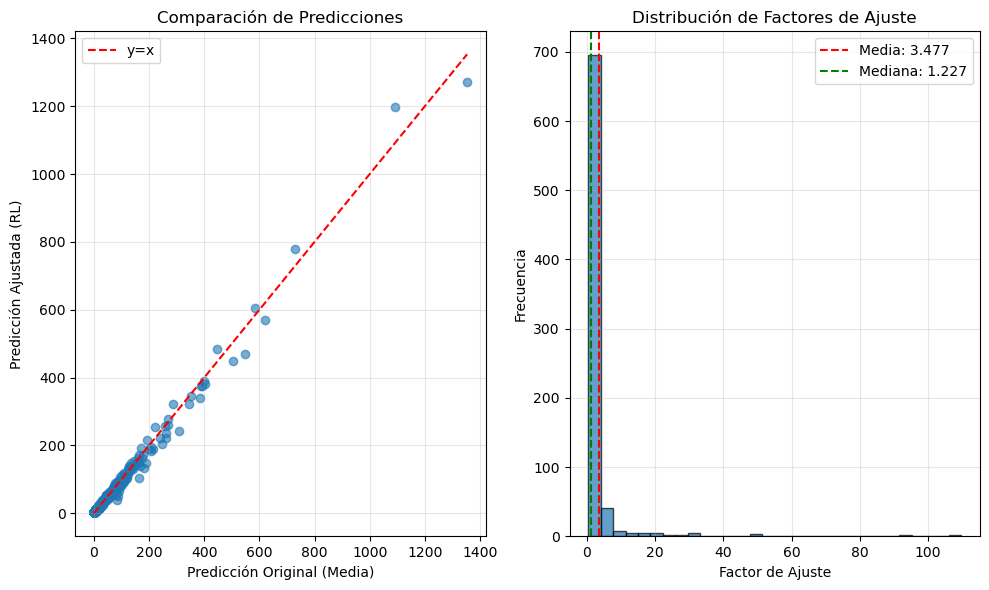


üìä Gr√°ficos generados para analizar el ajuste de 780 productos


In [103]:
# PASO 19 (Opcional): Visualizar la comparaci√≥n de predicciones
if pred_medias_093 is not None and len(productos_comunes) > 0:
    # Crear un scatter plot para comparar predicciones originales vs ajustadas
    plt.figure(figsize=(10, 6))
    
    # Subplot 1: Comparaci√≥n directa
    plt.subplot(1, 2, 1)
    plt.scatter(pred_medias_filtrado['tn'], pred_ajustado_final['tn'], alpha=0.6)
    plt.plot([0, pred_medias_filtrado['tn'].max()], [0, pred_medias_filtrado['tn'].max()], 'r--', label='y=x')
    plt.xlabel('Predicci√≥n Original (Media)')
    plt.ylabel('Predicci√≥n Ajustada (RL)')
    plt.title('Comparaci√≥n de Predicciones')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Distribuci√≥n de factores de ajuste
    plt.subplot(1, 2, 2)
    plt.hist(pred_medias_filtrado['factor_ajuste'], bins=30, alpha=0.7, edgecolor='black')
    plt.axvline(pred_medias_filtrado['factor_ajuste'].mean(), color='red', linestyle='--', 
                label=f'Media: {pred_medias_filtrado["factor_ajuste"].mean():.3f}')
    plt.axvline(pred_medias_filtrado['factor_ajuste'].median(), color='green', linestyle='--',
                label=f'Mediana: {pred_medias_filtrado["factor_ajuste"].median():.3f}')
    plt.xlabel('Factor de Ajuste')
    plt.ylabel('Frecuencia')
    plt.title('Distribuci√≥n de Factores de Ajuste')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nüìä Gr√°ficos generados para analizar el ajuste de {len(pred_medias_filtrado)} productos")

In [104]:
# PASO 20: Crear archivo con formato similar al de regresi√≥n lineal v2
# Creamos un archivo con los datos ajustados pero en el mismo formato que pred_regresion_lineal_v2_todos_los_datos.csv
if pred_medias_093 is not None and len(productos_comunes) > 0:
    # Crear DataFrame con el mismo formato que el archivo de regresi√≥n lineal v2
    pred_coef_final = pred_medias_filtrado[['product_id', 'tn_ajustado']].copy()
    pred_coef_final.rename(columns={'tn_ajustado': 'tn'}, inplace=True)
    
    # Ordenar por product_id para consistencia
    pred_coef_final.sort_values('product_id', inplace=True)
    pred_coef_final.reset_index(drop=True, inplace=True)
    
    # Guardar el archivo con el nombre solicitado
    filename_coef = "data/pred_coef_rl02_medias_093_12.csv"
    pred_coef_final.to_csv(filename_coef, index=False, encoding="utf-8")
    
    print(f"‚úì Archivo con coeficientes ajustados guardado: {filename_coef}")
    print(f"Total de productos: {len(pred_coef_final)}")
    print(f"Formato: {list(pred_coef_final.columns)}")
    
    # Mostrar estad√≠sticas del archivo creado
    print(f"\nEstad√≠sticas del archivo pred_coef_rl02_medias_093_12.csv:")
    print(f"- Productos incluidos: {len(pred_coef_final)}")
    print(f"- Suma total de tn: {pred_coef_final['tn'].sum():.2f}")
    print(f"- Promedio de tn: {pred_coef_final['tn'].mean():.2f}")
    print(f"- tn m√°ximo: {pred_coef_final['tn'].max():.2f}")
    print(f"- tn m√≠nimo: {pred_coef_final['tn'].min():.2f}")
    
    print(f"\nPrimeras 10 filas del archivo:")
    print(pred_coef_final.head(10))
    
    print(f"\n√öltimas 5 filas del archivo:")
    print(pred_coef_final.tail(5))
    
else:
    print("‚ùå No se pudo crear el archivo pred_coef_rl02_medias_093_12.csv")

‚úì Archivo con coeficientes ajustados guardado: data/pred_coef_rl02_medias_093_12.csv
Total de productos: 780
Formato: ['product_id', 'tn']

Estad√≠sticas del archivo pred_coef_rl02_medias_093_12.csv:
- Productos incluidos: 780
- Suma total de tn: 28805.38
- Promedio de tn: 36.93
- tn m√°ximo: 1272.04
- tn m√≠nimo: 2.30

Primeras 10 filas del archivo:
   product_id           tn
0       20001  1272.038684
1       20002  1196.271738
2       20003   779.366959
3       20004   605.713230
4       20005   569.928575
5       20006   483.541044
6       20007   379.999033
7       20008   375.582630
8       20009   447.498852
9       20010   390.494420

√öltimas 5 filas del archivo:
     product_id        tn
775       21263  2.572287
776       21265  2.653513
777       21266  2.655442
778       21267  2.635107
779       21276  2.591837


## Resumen de Archivos Generados

Se han creado cuatro archivos de predicciones con diferentes enfoques:

### 1. **pred_regresion_lineal_v2_todos_los_datos.csv**
- **M√©todo**: Regresi√≥n lineal pura entrenada con todos los datos de dic-2018
- **Caracter√≠sticas**: Modelo directo sin ajustes externos
- **Productos**: Todos los productos vigentes (780)

### 2. **pred_093_12_ajustado_rl02.csv** 
- **M√©todo**: Predicciones de medias ajustadas con factores de regresi√≥n lineal
- **Caracter√≠sticas**: Toma pred_medias_12_093.csv y lo multiplica por factores del modelo RL
- **Productos**: Solo productos comunes entre medias y dataset de entrenamiento

### 3. **pred_coef_rl02_medias_093_12.csv**
- **M√©todo**: Mismo que #2 pero con formato id√©ntico al archivo #1
- **Caracter√≠sticas**: Datos de medias ajustados en formato est√°ndar para comparaci√≥n
- **Productos**: Misma cantidad que #2

### 4. **pred_coef_rl02_trivial_12.csv** ‚≠ê NUEVO
- **M√©todo**: Predicciones triviales ajustadas con factores de regresi√≥n lineal
- **Caracter√≠sticas**: Toma pred_trivial_media12.csv y lo ajusta con coeficientes del modelo RL
- **Productos**: Solo productos comunes entre triviales y dataset de entrenamiento

**Recomendaci√≥n**: Comparar performance de los cuatro enfoques para seleccionar el mejor. Los archivos #3 y #4 permiten comparaci√≥n directa al tener el mismo formato.

## Ajuste de Predicciones Triviales con Coeficientes de Regresi√≥n Lineal

En esta secci√≥n vamos a aplicar el mismo proceso de ajuste pero usando las predicciones triviales:
1. Cargar las predicciones de `pred_trivial_media12.csv`
2. Aplicar los coeficientes del modelo de regresi√≥n lineal entrenado
3. Generar el archivo `pred_coef_rl02_trivial_12.csv`

In [105]:
# PASO 21: Cargar las predicciones triviales de media 12
# Cargamos el archivo pred_trivial_media12.csv que contiene las predicciones triviales base
try:
    pred_trivial_12 = pd.read_csv("data/pred_trivial_media12.csv")
    print(f"‚úì Archivo trivial cargado exitosamente: {len(pred_trivial_12)} productos")
    print(f"Columnas disponibles: {list(pred_trivial_12.columns)}")
    pred_trivial_12.head()
except FileNotFoundError:
    print("‚ùå Error: No se encontr√≥ el archivo data/pred_trivial_media12.csv")
    print("Verifica que el archivo existe en la carpeta data/")
    pred_trivial_12 = None

‚úì Archivo trivial cargado exitosamente: 780 productos
Columnas disponibles: ['product_id', 'tn']


In [106]:
# PASO 22: Calcular factor de ajuste para predicciones triviales
# Aplicamos el mismo proceso que con las medias pero usando las predicciones triviales
if pred_trivial_12 is not None:
    # Verificar productos en com√∫n entre pred_trivial_12 y dataset_final
    productos_comunes_trivial = set(pred_trivial_12['product_id']) & set(dataset_final['product_id'])
    print(f"Productos en com√∫n entre pred_trivial_12 y dataset_final: {len(productos_comunes_trivial)}")
    
    # Filtrar solo productos comunes
    pred_trivial_filtrado = pred_trivial_12[pred_trivial_12['product_id'].isin(productos_comunes_trivial)].copy()
    dataset_trivial_ajuste = dataset_final[dataset_final['product_id'].isin(productos_comunes_trivial)].copy()
    
    print(f"Productos triviales que se pueden ajustar: {len(pred_trivial_filtrado)}")
    
    # Mostrar estad√≠sticas de las predicciones triviales originales
    print(f"\nEstad√≠sticas predicciones triviales originales:")
    print(f"- Suma total: {pred_trivial_filtrado['tn'].sum():.2f}")
    print(f"- Promedio: {pred_trivial_filtrado['tn'].mean():.2f}")
    print(f"- M√°ximo: {pred_trivial_filtrado['tn'].max():.2f}")
    print(f"- M√≠nimo: {pred_trivial_filtrado['tn'].min():.2f}")
else:
    print("No se puede proceder sin el archivo de predicciones triviales")

Productos en com√∫n entre pred_trivial_12 y dataset_final: 780
Productos triviales que se pueden ajustar: 780

Estad√≠sticas predicciones triviales originales:
- Suma total: 30644.42
- Promedio: 39.29
- M√°ximo: 1454.73
- M√≠nimo: 0.03


In [107]:
# PASO 23: Aplicar ajuste de regresi√≥n lineal a predicciones triviales
if pred_trivial_12 is not None and len(productos_comunes_trivial) > 0:
    # Ordenar ambos DataFrames por product_id para asegurar alineaci√≥n
    pred_trivial_filtrado = pred_trivial_filtrado.sort_values('product_id').reset_index(drop=True)
    dataset_trivial_ajuste = dataset_trivial_ajuste.sort_values('product_id').reset_index(drop=True)
    
    # Generar predicciones del modelo de regresi√≥n para estos productos
    X_trivial_ajuste = dataset_trivial_ajuste[feature_cols]
    prediccion_rl_trivial = lr.predict(X_trivial_ajuste)
    
    # Calcular factor de ajuste: predicci√≥n_RL / predicci√≥n_trivial
    pred_trivial_filtrado['prediccion_rl'] = prediccion_rl_trivial
    
    # Evitar divisi√≥n por cero
    pred_trivial_filtrado['factor_ajuste'] = np.where(
        pred_trivial_filtrado['tn'] != 0,
        pred_trivial_filtrado['prediccion_rl'] / pred_trivial_filtrado['tn'],
        1.0  # Si la predicci√≥n trivial original es 0, no ajustamos
    )
    
    # Aplicar el ajuste
    pred_trivial_filtrado['tn_ajustado'] = pred_trivial_filtrado['tn'] * pred_trivial_filtrado['factor_ajuste']
    
    print("Estad√≠sticas del ajuste para predicciones triviales:")
    print(f"Factor de ajuste promedio: {pred_trivial_filtrado['factor_ajuste'].mean():.4f}")
    print(f"Factor de ajuste mediano: {pred_trivial_filtrado['factor_ajuste'].median():.4f}")
    print(f"Rango del factor: {pred_trivial_filtrado['factor_ajuste'].min():.4f} - {pred_trivial_filtrado['factor_ajuste'].max():.4f}")
    
    print("\nComparaci√≥n antes y despu√©s del ajuste:")
    print(f"Suma original (trivial): {pred_trivial_filtrado['tn'].sum():.2f}")
    print(f"Suma ajustada: {pred_trivial_filtrado['tn_ajustado'].sum():.2f}")
    print(f"Diferencia: {(pred_trivial_filtrado['tn_ajustado'].sum() - pred_trivial_filtrado['tn'].sum()):.2f}")
    
    pred_trivial_filtrado[['product_id', 'tn', 'prediccion_rl', 'factor_ajuste', 'tn_ajustado']].head(10)

Estad√≠sticas del ajuste para predicciones triviales:
Factor de ajuste promedio: 3.2338
Factor de ajuste mediano: 1.1413
Rango del factor: 0.4242 - 102.0483

Comparaci√≥n antes y despu√©s del ajuste:
Suma original (trivial): 30644.42
Suma ajustada: 28805.38
Diferencia: -1839.04


In [108]:
# PASO 24: Crear archivo final para predicciones triviales ajustadas
if pred_trivial_12 is not None and len(productos_comunes_trivial) > 0:
    # Crear DataFrame con formato est√°ndar para predicciones triviales ajustadas
    pred_trivial_coef_final = pred_trivial_filtrado[['product_id', 'tn_ajustado']].copy()
    pred_trivial_coef_final.rename(columns={'tn_ajustado': 'tn'}, inplace=True)
    
    # Ordenar por product_id para consistencia
    pred_trivial_coef_final.sort_values('product_id', inplace=True)
    pred_trivial_coef_final.reset_index(drop=True, inplace=True)
    
    # Guardar el archivo con el nombre solicitado
    filename_trivial_coef = "data/pred_coef_rl02_trivial_12.csv"
    pred_trivial_coef_final.to_csv(filename_trivial_coef, index=False, encoding="utf-8")
    
    print(f"‚úì Archivo trivial ajustado guardado: {filename_trivial_coef}")
    print(f"Total de productos: {len(pred_trivial_coef_final)}")
    print(f"Formato: {list(pred_trivial_coef_final.columns)}")
    
    # Mostrar estad√≠sticas del archivo creado
    print(f"\nEstad√≠sticas del archivo pred_coef_rl02_trivial_12.csv:")
    print(f"- Productos incluidos: {len(pred_trivial_coef_final)}")
    print(f"- Suma total de tn: {pred_trivial_coef_final['tn'].sum():.2f}")
    print(f"- Promedio de tn: {pred_trivial_coef_final['tn'].mean():.2f}")
    print(f"- tn m√°ximo: {pred_trivial_coef_final['tn'].max():.2f}")
    print(f"- tn m√≠nimo: {pred_trivial_coef_final['tn'].min():.2f}")
    
    print(f"\nPrimeras 10 filas del archivo:")
    print(pred_trivial_coef_final.head(10))
    
    print(f"\n√öltimas 5 filas del archivo:")
    print(pred_trivial_coef_final.tail(5))
    
else:
    print("‚ùå No se pudo crear el archivo pred_coef_rl02_trivial_12.csv")

‚úì Archivo trivial ajustado guardado: data/pred_coef_rl02_trivial_12.csv
Total de productos: 780
Formato: ['product_id', 'tn']

Estad√≠sticas del archivo pred_coef_rl02_trivial_12.csv:
- Productos incluidos: 780
- Suma total de tn: 28805.38
- Promedio de tn: 36.93
- tn m√°ximo: 1272.04
- tn m√≠nimo: 2.30

Primeras 10 filas del archivo:
   product_id           tn
0       20001  1272.038684
1       20002  1196.271738
2       20003   779.366959
3       20004   605.713230
4       20005   569.928575
5       20006   483.541044
6       20007   379.999033
7       20008   375.582630
8       20009   447.498852
9       20010   390.494420

√öltimas 5 filas del archivo:
     product_id        tn
775       21263  2.572287
776       21265  2.653513
777       21266  2.655442
778       21267  2.635107
779       21276  2.591837


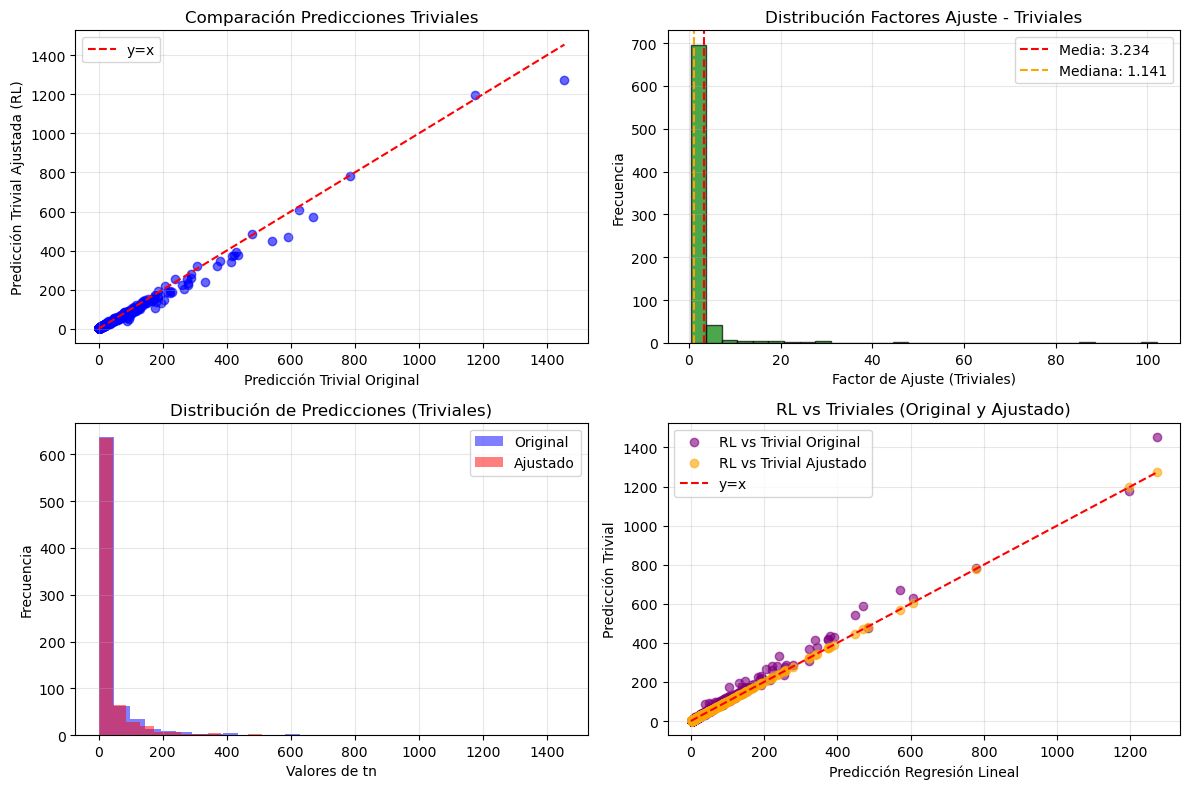


üìä Gr√°ficos de an√°lisis trivial generados para 780 productos


In [109]:
# PASO 25 (Opcional): Visualizar comparaci√≥n de predicciones triviales
if pred_trivial_12 is not None and len(productos_comunes_trivial) > 0:
    # Crear visualizaci√≥n para comparar predicciones triviales originales vs ajustadas
    plt.figure(figsize=(12, 8))
    
    # Subplot 1: Comparaci√≥n directa triviales
    plt.subplot(2, 2, 1)
    plt.scatter(pred_trivial_filtrado['tn'], pred_trivial_coef_final['tn'], alpha=0.6, color='blue')
    plt.plot([0, pred_trivial_filtrado['tn'].max()], [0, pred_trivial_filtrado['tn'].max()], 'r--', label='y=x')
    plt.xlabel('Predicci√≥n Trivial Original')
    plt.ylabel('Predicci√≥n Trivial Ajustada (RL)')
    plt.title('Comparaci√≥n Predicciones Triviales')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Distribuci√≥n de factores triviales
    plt.subplot(2, 2, 2)
    plt.hist(pred_trivial_filtrado['factor_ajuste'], bins=30, alpha=0.7, edgecolor='black', color='green')
    plt.axvline(pred_trivial_filtrado['factor_ajuste'].mean(), color='red', linestyle='--', 
                label=f'Media: {pred_trivial_filtrado["factor_ajuste"].mean():.3f}')
    plt.axvline(pred_trivial_filtrado['factor_ajuste'].median(), color='orange', linestyle='--',
                label=f'Mediana: {pred_trivial_filtrado["factor_ajuste"].median():.3f}')
    plt.xlabel('Factor de Ajuste (Triviales)')
    plt.ylabel('Frecuencia')
    plt.title('Distribuci√≥n Factores Ajuste - Triviales')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 3: Comparaci√≥n de distribuciones de tn
    plt.subplot(2, 2, 3)
    plt.hist(pred_trivial_filtrado['tn'], bins=30, alpha=0.5, label='Original', color='blue')
    plt.hist(pred_trivial_coef_final['tn'], bins=30, alpha=0.5, label='Ajustado', color='red')
    plt.xlabel('Valores de tn')
    plt.ylabel('Frecuencia')
    plt.title('Distribuci√≥n de Predicciones (Triviales)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 4: Comparaci√≥n RL vs Trivial vs Ajustado
    plt.subplot(2, 2, 4)
    plt.scatter(pred_trivial_filtrado['prediccion_rl'], pred_trivial_filtrado['tn'], 
                alpha=0.6, label='RL vs Trivial Original', color='purple')
    plt.scatter(pred_trivial_filtrado['prediccion_rl'], pred_trivial_coef_final['tn'], 
                alpha=0.6, label='RL vs Trivial Ajustado', color='orange')
    plt.plot([0, pred_trivial_filtrado['prediccion_rl'].max()], 
             [0, pred_trivial_filtrado['prediccion_rl'].max()], 'r--', label='y=x')
    plt.xlabel('Predicci√≥n Regresi√≥n Lineal')
    plt.ylabel('Predicci√≥n Trivial')
    plt.title('RL vs Triviales (Original y Ajustado)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nüìä Gr√°ficos de an√°lisis trivial generados para {len(pred_trivial_filtrado)} productos")